In [1]:
%cd ../

/Users/sarchey1/paper/FederatedLearning


In [2]:
import warnings
warnings.simplefilter('ignore')

## Stochastic Block Model Experiment

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../gradient_federated.png)

In [296]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def algorithm_1(K, D, weight_vec, features, true_labels, samplingset, datapoints, lambda_lasso, calculate_score=True, alpha=0.02):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param features: a list containing the local datapints of the nodes
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    alpha = 0.02
    E, N = D.shape
    m, n = features[0].shape

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    iterations = K

    iteration_scores = []
    for iterk in range(K):
        prev_w = np.copy(new_w)
        # line 2 of Gradient descent for networked FL
        new_w = np.array([np.zeros(n) for i in range(N)])

        # line 3 of Gradient descent for networked FL
        for i in range(N):
            if i in samplingset:  
                # line 4 of Gradient descent for networked FL
#                 optimizer = datapoints[i]['optimizer']
#                 new_w[i] = 1/m * optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], prev_w[i], datapoints[i]['degree'])
                
                # line 4 of Gradient descent for networked FL
                var = np.dot(features[i], prev_w[i]) - true_labels[i]
                new_w[i] = 1/m * np.dot(features[i].T, var)


        # line 6 of Gradient descent for networked FL
        for e in range(E):
            i = np.where(D[e]==1)[0]
            j = np.where(D[e]==-1)[0]
            
            # line 7 of Gradient descent for networked FL
            tilde_w = lambda_lasso * weight_vec[e] * (prev_w[j] - prev_w[i])
            
            # line 8 of Gradient descent for networked FL
            new_w[i] = new_w[i] - tilde_w
            
            # line 9 of Gradient descent for networked FL
            new_w[j] = new_w[j] + tilde_w
            

        # line 11 of Gradient descent for networked FL
        new_w = prev_w - alpha * new_w

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            alg1_score = get_algorithm1_w_MSE(new_w, samplingset.copy(), datapoints.copy())['total']
            iteration_scores.append(alg1_score)
            
#             if iterk > 1:
#                 print(iterk, iteration_scores[-2] - iteration_scores[-1], iteration_scores[-1], iteration_scores[-2])
            if iterk > 10 and (iteration_scores[-2] - iteration_scores[-1])/iteration_scores[-2] < 0.005:
                iterations = iterk
                break

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w, iterations


### Joona's implementation

In [4]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F


def joonas_algorithm_1(K, D, weight_vec, features, true_labels, samplingset, lambda_lasso, calculate_score=False, a = 0.02):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param features: a list containing the local datapints of the nodes
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    E, N = D.shape
    m, n = features[0].shape

    # starting algorithm 1

    # step size, 0.0001
    # last 0.05
    
    D = torch.Tensor(D)
    weight_vec = torch.Tensor(weight_vec)
    
    iteration_scores = []
    
    model_params = list()
    models = []
    for i in range(N):
        model = TorchLinearModel(n)
        models.append(model)
        model_params += list(model.parameters())

    optim = torch.optim.SGD(model_params, lr=a)
    prev_loss = 0
    iterations = K
    
    for iterk in range(K):
        optim.zero_grad()
        # Shared loss over all nodes
        loss = 0
        # f(w) (training error/loss)
        for i in samplingset:
            x_i = torch.Tensor(features[i])
            y_i = torch.Tensor(true_labels[i]).reshape(-1, 1)
            y_pred = models[i](x_i)
            loss1 = F.mse_loss(y_pred, y_i)
            loss += loss1
                
        # GTV
        # weight_vec is A (edge weights)
        # D is sort of adjacency matrix? +1 on j and -1 on i
        # new_w has the current weights
        new_w = torch.cat([models[i].linear.weight for i in range(N)])
        # w_j - w_i = D @ new_w
        norm_squared = torch.square(torch.linalg.norm(D @ new_w, dim=1))
        loss2 = lambda_lasso * torch.dot(weight_vec, norm_squared)
        loss += loss2
        
#         print("epoch:", iterk)
#         print("loss", loss.item())
        if prev_loss - loss < 0.0005 and prev_loss - loss >= 0:
            iterations = iterk
            break
        else:
            prev_loss = loss
        
        loss.backward()
        optim.step()
        

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(models[i](features[i]))
            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))
    
    new_w = np.array([models[i].linear.weight.data.numpy() for i in range(N)]).reshape((N, -1))

    return iteration_scores, new_w, iterations



## primal dual implementation

In [5]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def primal_dual_algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(D), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

#     if np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2) > 1:
#         print ('product norm', np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2))

    E, N = D.shape
    m, n = datapoints[0]['features'].shape

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        prev_w = np.copy(new_w)

        # algorithm 1, line 2
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))

        for i in range(N):
            if i in samplingset:  # algorithm 1, line 6

                optimizer = datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], hat_w[i], datapoints[i]['degree'])

            else:
                new_w[i] = hat_w[i]

        # algorithm 1, line 9
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        # algorithm 1, line 10
        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w



# %load algorithm/optimizer.py 
import torch
import abc
import numpy as np

from abc import ABC


# The linear model which is implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


# The abstract optimizer model which should have model, optimizer, and criterion as the input
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(40):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2)  # + 10000*torch.mean((model.linear.bias+0.5)**2)#model.linear.weight.norm(2)
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()


# The linear model in Networked Linear Regression section of the paper
class LinearModel:
    def __init__(self, degree, features, label):
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)

        mtx2 = 2 * degree * np.dot(features.T, label).T

        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)


# The Linear optimizer in Networked Linear Regression section of the paper
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return self.model.forward(old_weight)


# The Linear optimizer model which is implemented by pytorch
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


# The Logistic optimizer model which is implemented by pytorch
class TorchLogisticOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLogisticOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLogisticOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)



# %load algorithm/penalty.py
import abc
import numpy as np

from abc import ABC


# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u


# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u




### FedAvg

In [6]:
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def fedAvg(K, datapoints, true_labels, samplingset, calculate_score=False):
    '''
    :param K: the number of iterations
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    N = len(datapoints)
    m, n = datapoints[0]['features'].shape

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the weights
    '''

    iteration_scores = []
    for iterk in range(K):
        for i in samplingset:
            optimizer = datapoints[i]['optimizer']
            new_w[i] = optimizer.optimize(
                datapoints[i]['features'], 
                datapoints[i]['label'], 
                new_w[i], 
                datapoints[i]['degree']
            )
        new_w[:, :] = np.mean(new_w[samplingset], axis=0)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w



### IFCA

In [7]:
import argparse
import json
import os
import time
import itertools
import pickle

import torch
import numpy as np

LR_DECAY = False


def ifca_main(datapoints):
    config = {
        "m" : 200,            # number of machines
        "p" : 2,              # number of cluster groups (expects m % p == 0)
        "n" : 100,            # number of datapoints for each machine
        "d" : 1000,           # dimension of the datapoint
        "r" : 1.0,            # separation parameter for synthetic data generation
        "noise_scale": 0.001, # noise parameter (\sigma)  for synthetic data generation
        "num_epochs": 300,    # number of data pass
#         "num_epochs": 1000,    # number of data pass
        "score":"set",        # scoring method ( only 'set' is used)
        "lr":0.1,             # learning rate
        "data_seed":0,        # random seed for generating data
        "train_seed":0 
    }
    config['m'] = len(datapoints)
    config['n'] = datapoints[0]['features'].shape[0]
    config['d'] = datapoints[0]['features'].shape[1]
    
    dataset_generate = DatasetGenerate(config)
    dataset_generate.setup()
    dataset = dataset_generate.generate_dataset(datapoints)

    exp = TrainCluster(config)
    exp.setup(dataset= dataset)
    results = exp.run()
    return results, exp


def random_normal_tensor(size, loc = 0, scale = 1):
    return torch.randn(size) * scale + loc


class DatasetGenerate(object):
    def __init__(self, config, seed = 0):
        self.seed = 0
        self.config = config

        assert self.config['m'] % self.config['p'] == 0

    def setup(self):
        # print('seeding', self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

        # param settings
        # p even -> loc: [-3, -1, 1, 3] p = 4
        # p odd -> loc: [-6, -4, -2, 0, 2, 4, 6] p = 7
        p = int(self.config['p'])
        self.param_settings = [ -p + 1 + 2*i for i in range(p)]


    def generate_dataset(self, datapoints):
        dataset = {}
        dataset['config'] = self.config
        
#         dataset['params'] = params
        dataset['data'] = []
        

        m = len(datapoints)
        p = self.config['p']
        # generate dataset for each machine
        cluster_assignment = [m_i//(m//p) for m_i in range(m)] # ex: [0,0,0,0, 1,1,1,1, 2,2,2,2] for m = 12, p = 3
        dataset['cluster_assignment'] = cluster_assignment
        
        params = []
        params.append(datapoints[0]['w'])
        params.append(datapoints[m-1]['w'])

        dataset['params'] = params
        
        for m_i in range(m):
            features = datapoints[m_i]['features']
            label = datapoints[m_i]['label']
            
            data_X = Variable(torch.from_numpy(features)).to(torch.float32)
            data_y = Variable(torch.from_numpy(label)).to(torch.float32)

            dataset['data'].append((data_X, data_y))

        self.dataset = dataset
        return dataset
#         p = self.config['p']
#         d = self.config['d']
#         m = self.config['m']
#         n = self.config['n']


#         dataset = {}
#         dataset['config'] = self.config

#         # generate parameter set for each cluster
#         params = []
#         for p_i in range(p):
#             loc = self.param_settings[p_i]

#             param = torch.tensor(np.random.binomial(1, 0.5, size=(d)).astype(np.float32)) * self.config['r']

#             params.append(param)

#         dataset['params'] = params
#         dataset['data'] = []

#         # generate dataset for each machine
#         cluster_assignment = [m_i//(m//p) for m_i in range(m)] # ex: [0,0,0,0, 1,1,1,1, 2,2,2,2] for m = 12, p = 3
#         dataset['cluster_assignment'] = cluster_assignment

#         for m_i in range(m):
#             p_i = cluster_assignment[m_i]

#             data_X = random_normal_tensor(size=(n,d))
#             data_y = data_X @ params[p_i]

#             noise_y = random_normal_tensor(size=(n), scale = self.config['noise_scale'] )
#             data_y = data_y + noise_y

#             dataset['data'].append((data_X, data_y))

#         self.dataset = dataset
#         return dataset
        
        
class TrainCluster(object):
    def __init__(self, config):
        self.seed = config['train_seed']
        self.config = config

        assert self.config['m'] % self.config['p'] == 0

    def setup(self, dataset = None):
        # print('seeding', self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

        if dataset != None:
            self.dataset = dataset
        else:
            raise exception('dataset is none')

        p = self.config['p']
        d = self.config['d']
        m = self.config['m']
        n = self.config['n']

        self.models = [ SimpleLinear(input_size=d) for p_i in range(p)] # p models with p different params of dimension(1,d)
        self.criterion = torch.nn.MSELoss()

        self.epoch = None

        self.lr_decay_info = None


    def run(self):
        num_epochs = self.config['num_epochs']
        lr = self.config['lr']
        self.initialize_weights()
        # self.warm_start()
        results = []

        for epoch in range(num_epochs):
            self.epoch = epoch
            result = self.train(lr = lr)

            result['epoch'] = epoch
            results.append(result)

#             print(f" epoch {self.epoch} min_loss {result['min_loss']:3f} min_dist {result['min_dist']:3f} lr {lr:.5f}")
            # print(f"      min_losses {result['min_losses']}")
#             print(result["cluster_assignment_ct"], result["closest_cluster"])

            if LR_DECAY and self.determine_lr_decay(result):
                # lr = lr * 0.1
                lr = lr * 0.8

            if LR_DECAY and lr < 0.0001:
                print('break due to lr < 0.0001 in epoch', epoch)
                break

        return results


    def cleanup(self):
#         os.remove(self.dataset_fname)
        pass


    def determine_lr_decay(self,result):

        if self.lr_decay_info == None:
            self.lr_decay_info = {}
            dd = self.lr_decay_info
            dd['ct'] = 0
            dd['loss'] = -1

        dd = self.lr_decay_info
        if dd['loss']== -1:
            dd['loss'] = result['min_loss']
        else:
            if dd['loss'] - 1.0 > result['min_loss']:
                # still converging
                dd['ct'] = 0
                dd['loss'] = result['min_loss']
            else:
                # maybe converged
                dd['ct'] += 1

        if dd['ct'] > 5:
            dd['loss'] = result['min_loss']
            dd['ct'] = 0
            return True
        else:
            return False


    def train(self, lr):
        p = self.config['p']
        d = self.config['d']
        m = self.config['m']
        n = self.config['n']
        result = {}

        # calc loss and grad
        losses = {}
        grads = {}
        for m_i in range(m):
            for p_i in range(p):
                (X, y) = self.dataset['data'][m_i]

                loss_val, grad = calculate_loss_grad(self.models[p_i], self.criterion, X, y )
                losses[(m_i,p_i)] = loss_val
                grads[(m_i,p_i)] = grad

        # calculate scores
        scores = {}
        for m_i in range(m):
            machine_losses = [ losses[(m_i,p_i)] for p_i in range(p) ]

            if self.config['score'] == 'set':
                min_p_i = np.argmin(machine_losses)
                for p_i in range(p):
                    if p_i == min_p_i:
                        scores[(m_i,p_i)] = 1
                    else:
                        scores[(m_i,p_i)] = 0

            elif self.config['score'] == 'em':

                from scipy.special import softmax
                softmaxed_loss = softmax(machine_losses)
                for p_i in range(p):
                    scores[(m_i,p_i)] = softmaxed_loss[p_i]

            else:
                assert self.config['score'] in ['set', 'em']

        # apply gradient update
        for p_i in range(p):
            cluster_scores = [ scores[(m_i,p_i)] for m_i in range(m) ]
            cluster_grads = [ grads[(m_i,p_i)] for m_i in range(m) ]

            self.models[p_i].zero_grad()
            weight = self.models[p_i].weight()
            tmp = gradient_update(cluster_scores, cluster_grads)
            weight.data -= lr * tmp

        # evaluate min_losses
        min_losses = []
        cluster_assignment = []
        for m_i in range(m):
            machine_losses = [ losses[(m_i,p_i)] for p_i in range(p) ]
            min_loss = np.min(machine_losses)
            min_losses.append(min_loss)

            machine_scores = [ scores[(m_i,p_i)] for p_i in range(p) ]
            assign = np.argmax(machine_scores)

            cluster_assignment.append(assign)



        result["min_loss"] = np.mean(min_losses)
        result["min_losses"] = min_losses
        result['cluster_assignment'] = cluster_assignment

        cluster_assignment_ct = [0 for p_i in range(p)]
        for m_i in range(m):
            cluster_assignment_ct[cluster_assignment[m_i]] += 1

        result["cluster_assignment_ct"] = cluster_assignment_ct

        closest_cluster = [-1 for _ in range(p)]
        min_dists = []
        for p_i in range(p):
            weight = self.models[p_i].weight()
            distances = []
            for p_j in range(p):
                param_ans = self.dataset['params'][p_j]
                distances.append(torch.norm(weight.data - param_ans, 2))
            closest_cluster[p_i] = np.argmin(distances)
            min_dist = np.min(distances)
            min_dists.append(min_dist)

        result["min_dist"] = np.mean(min_dists)
        result["min_dists"] = min_dists

        result["closest_cluster"] = closest_cluster


        return result

    def initialize_weights(self):
        p = self.config['p']
        random_number = np.random.normal() # dummy

        for p_i in range(p):
            weight = self.models[p_i].weight()
            d = weight.shape[1]
            param = torch.tensor(np.random.binomial(1, 0.5, size=(1,d)).astype(np.float32)) *1.0
            weight.data = param


    def warm_start(self):

        noise_scale = 5.0

        p = self.config['p']

        for p_i in range(p):
            weight = self.models[p_i].weight()
            param_ans = self.dataset['params'][p_i]

            noise = random_normal_tensor(size=weight.data.shape, loc = 0, scale = noise_scale)
            weight.data = param_ans + noise

        # compare the distance the distance to verify
        closest_cluster = [-1 for _ in range(p)]
        for p_i in range(p):
            weight = self.models[p_i].weight()
            distances = []
            for p_j in range(p):
                param_ans = self.dataset['params'][p_j]
                distances.append(torch.norm(weight.data - param_ans, 2))
            closest_cluster[p_i] = np.argmin(distances)

        assert closest_cluster == list(range(p)), f"closest_cluster {closest_cluster} != list(range(p))"

###   ####  ###

def calculate_loss_grad(model, criterion, X, y):
    y_target = model(X)
    loss = criterion(y, y_target)
    model.zero_grad()
    loss.backward()

    loss_value = loss.item()
    weight = model.weight()
    d_weight = weight.grad.clone()

    return loss_value, d_weight

def gradient_update(scores, grads):
    m = len(grads)
    tmp = torch.zeros_like(grads[0])
    for m_i in range(m):
        tmp += scores[m_i] * grads[m_i]
    tmp /= m

    return tmp



class SimpleLinear(torch.nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, 1, bias=False)

    def weight(self):
        return self.linear1.weight

    def forward(self, x):
        return self.linear1(x).view(-1) # 1 dim
    
    
def get_ifca_error(results, train_cluster):
    true_labels = []
    pred_labels = []
    for i in range(len(train_cluster.dataset['data'])):
        features = train_cluster.dataset['data'][i][0]
        label = train_cluster.dataset['data'][i][1]
        true_labels.append(label.detach().numpy())

        clust_assign = results[-1]['cluster_assignment'][i]
        pred_label = train_cluster.models[clust_assign](features).detach().numpy()
        pred_labels.append(pred_label)

    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)

    return {'total': mean_squared_error(true_labels, pred_labels)}




## Create SBM Graph

The stochastic block model is a generative model for random graphs with some clusters structure. Two nodes within the same cluster of the empirical graph are connected by an edge with probability pin, two nodes from different clusters are connected by an edge with probability pout. Each node $i \in V$ represents a local dataset consisting of $m$ feature vectors $x^{(i,1)}, ... , x^{(i,m)} \in R^n$. The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ∼ N(0,I). The labels $y_1^{(i)}, . . . , y_m^{(i)} \in R$ of the nodes $i \in V$ are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon ∼ N(0,\sigma)$. To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes.

In [8]:
from algorithm.optimizer import *
from torch.autograd import Variable


def get_sbm_data(cluster_sizes, G, W, m=5, n=2, noise_sd=0):
    '''
    :param G: generated SBM graph with defined clusters using sparsebm.generate_SBM_dataset
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = len(G.nodes)
    E = len(G.edges)
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    for i, j in G.edges:
        if i > j:
            continue
        B[cnt, i] = 1
        B[cnt, j] = -1

        weight_vec[cnt] = 1
        cnt += 1
    
    weight_vec = weight_vec[:cnt]
    B = B[:cnt, :]
    
    # create the data of each node needed for the algorithm 1 
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    cnt = 0
    for i, cluster_size in enumerate(cluster_sizes):
        for j in range(cluster_size):
            features = np.random.normal(loc=0.0, scale=1.0, size=(m, n))
            '''
            features: the feature vector of node i which are i.i.d. realizations of a standard Gaussian random vector x~N(0,I)
            '''
            label = np.dot(features, W[i]) + np.random.normal(0,noise_sd)
            '''
            label: the label of the node i that is generated according to the linear model y = x^T w + e
            '''
            
            true_labels.append(label)

            model = LinearModel(node_degrees[i], features, label)
            optimizer = LinearOptimizer(model)            
            '''
            model : the linear model for the node i 
            optimizer : the optimizer model for the node i 
            ''' 
            
            datapoints[cnt] = {
                'features': features,
                'degree': node_degrees[i],
                'label': label,
                'optimizer': optimizer,
                'w': W[i], 
            }
            cnt += 1
            
    
    features = [datapoints[i]['features'] for i in datapoints]

    return B, weight_vec, features, np.array(true_labels), datapoints




### Compare Results

As the result we compare the MSE of Algorithm 1 with plain linear regression 
and decision tree regression

In [292]:
# %load results/compare_results.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


def get_algorithm1_MSE(all_features, labels, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(all_features)) if i not in samplingset]

    true_labels = []
    pred_labels = []
    for i in range(len(all_features)):
        features = np.array(all_features[i])
        label = np.array(labels[i])
        true_labels.append(label)

        pred_labels.append(np.dot(features, predicted_w[i]))

    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)

    alg1_MSE = {'total': mean_squared_error(true_labels, pred_labels),
                'train': mean_squared_error(true_labels[samplingset], pred_labels[samplingset]),
                'test': mean_squared_error(true_labels[not_samplingset], pred_labels[not_samplingset])}

    return alg1_MSE

def get_algorithm1_w_MSE(predicted_w, samplingset, datapoints):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(datapoints)) if i not in samplingset]
    true_w = []
    for i in datapoints:
        true_w.append(datapoints[i]['w'])
    
    predicted_w = np.array(predicted_w)
    true_w = np.array(true_w)

    alg1_MSE = {'total': mean_squared_error(true_w, predicted_w),
                'train': mean_squared_error(true_w[samplingset], predicted_w[samplingset]),
                'test': mean_squared_error(true_w[not_samplingset], predicted_w[not_samplingset])}

    return alg1_MSE


def get_linear_regression_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return linear_regression_MSE : the MSE of linear regression for all the nodes, the samplingset and other nodes (test set)
    '''

    model = LinearRegression().fit(x[samplingset], y[samplingset])
    pred_y = model.predict(x)

    linear_regression_MSE = {'total': mean_squared_error(y, pred_y),
                             'train': mean_squared_error(y[samplingset],
                                                         pred_y[samplingset]),
                             'test': mean_squared_error(y[not_samplingset],
                                                        pred_y[not_samplingset])}

    return linear_regression_MSE


def get_decision_tree_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return decision_tree_MSE : the MSE of decision tree for all the nodes, the samplingset and other nodes (test set)
    '''

    max_depth = 2

    regressor = DecisionTreeRegressor(max_depth=max_depth)
    regressor.fit(x[samplingset], y[samplingset])
    pred_y = regressor.predict(x)

    decision_tree_MSE = {'total': mean_squared_error(y, pred_y),
                         'train': mean_squared_error(y[samplingset],
                                                     pred_y[samplingset]),
                         'test': mean_squared_error(y[not_samplingset],
                                                    pred_y[not_samplingset])}
    return decision_tree_MSE


def get_scores(features, labels, primal_dual_w, predicted_w, joona_w, fl_w, samplingset, others=True):
    N = len(features)
    '''
    N : the total number of nodes
    '''

    # calculate algorithm1 MSE
    alg_1_score = get_algorithm1_MSE(features, labels, predicted_w, samplingset)
    primal_dual_score = get_algorithm1_MSE(features, labels, primal_dual_w, samplingset)
    joonas_score = get_algorithm1_MSE(features, labels, joona_w, samplingset)
    fl_score = get_algorithm1_MSE(features, labels, fl_w, samplingset)
    
    linear_regression_score = None
    decision_tree_score = None

    if others:
        # prepare the data for calculating the linear regression and decision tree regression MSEs
        X = []
        '''
        X: an array containing the features of all the nodes
        '''
        true_labels = []
        '''
        true_labels: an array containing the labels of all the nodes
        '''
        for i in range(len(datapoints)):
            X.append(np.array(datapoints[i]['features']))
            true_labels.append(np.array(datapoints[i]['label']))

        X = np.array(X)
        true_labels = np.array(true_labels)
        m, n = X[0].shape

        x = X.reshape(-1, n)
        y = true_labels.reshape(-1, 1)

        reformated_samplingset = []
        for item in samplingset:
            for i in range(m):
                reformated_samplingset.append(m * item + i)
        reformated_not_samplingset = [i for i in range(m * N) if i not in reformated_samplingset]
        
        # calculate linear regression MSE
        linear_regression_score = get_linear_regression_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

        # calculate decision tree MSE
        decision_tree_score = get_decision_tree_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

    return alg_1_score, joonas_score, primal_dual_score, fl_score, linear_regression_score, decision_tree_score


### SBM with Two Clusters

This SBM has two clusters $|C_1| = |C_2| = 100$.
Two nodes within the same cluster are connected by an edge with probability `pin=0.5`, 
and two nodes from different clusters are connected by an edge with probability `pout=0.01`. 
Each node $i \in V$ represents a local dataset consisting of feature vectors $x^{(i,1)}, ... , x^{(i,5)} \in R^2$.
The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ~ N(0,I).
The labels $y_1^{(i)}, . . . , y_5^{(i)} \in R$ for each node $i \in V$
are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon = 0$. 
The tuning parameter $\lambda$ in algorithm1 
is manually chosen, guided by the resulting MSE, as $\lambda=0.01$ for norm1 and norm2 and also $\lambda=0.05$ for mocha penalty function. 
To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes and use the rest as test set. As the result we compare the mean MSE of Algorithm 1 with plain linear regression and decision tree regression with respect to the different random sampling sets.

In [176]:
# %%capture
# # from sparsebm import generate_SBM_dataset
# import networkx as nx


# def get_sbm_2blocks_data(m=5, n=2, pin=0.5, pout=0.01, noise_sd=0):
#     '''
#     :param m, n: shape of features vector for each node
#     :param pin: the probability of edges inside each cluster
#     :param pout: the probability of edges between the clusters
#     :param noise_sd: the standard deviation of the noise for calculating the labels
    
#     :return B: adjacency matrix of the graph
#     :return weight_vec: a list containing the edges's weights of the graph
#     :return true_labels: a list containing the true labels of the nodes
#     :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
#     '''
#     cluster_sizes = [50, 50]
#     probs = np.array([[pin, pout],[pout, pin]])

#     G = nx.stochastic_block_model(cluster_sizes, probs, seed=0)
#     '''
#     G: generated SBM graph with 2 clusters
#     ''' 
    
#     # define weight vectors for each cluster of the graph
    
#     W1 = np.array([2 for i in range(n)])
#     '''
#     W1: the weigh vector for the first cluster
#     '''
#     W2 = np.array([-2 for i in range(n)])
#     '''
#     W2: the weigh vector for the second cluster
#     '''
    
#     W = [W1, W2]
    
    
#     return get_sbm_data(cluster_sizes, G, W, m, n, noise_sd)



In [38]:
def get_sbm(c=2, p1 = 0.4, p2 = 0.1, n_nodes = 10, n_data = 100, d_data = 1):
    N_c = n_nodes
    N = N_c * c
    B = []
    weight_vec = []
    
    for i in range(c):
        for idx1 in range(n_nodes * i, n_nodes * (i + 1)):
            for idx2 in range(idx1 + 1, n_nodes * (i + 1)):
                if p1 > np.random.random():
                    b = np.zeros(N)
                    if idx1 < idx2:
                        b[idx1] = 1
                        b[idx2] = -1
                    else:
                        b[idx1] = -1
                        b[idx2] = 1
                    weight_vec.append(1)
                    B.append(b)
                
    # Add edges between components (intercomponent edges)
    for i in range(c):
        for idx1 in range(n_nodes * i, n_nodes * (i + 1)):
            for i2 in range(i+1, c):
                for idx2 in range(n_nodes * i2, n_nodes * (i2 + 1)):
                    if p2 > np.random.random():
                        b = np.zeros(N)
                        if idx1 < idx2:
                            b[idx1] = 1
                            b[idx2] = -1
                        else:
                            b[idx1] = -1
                            b[idx2] = 1
                        weight_vec.append(1)
                        B.append(b)
     
    B = np.array(B)
    weight_vec = np.array(weight_vec)
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    
    datapoints = {}
    true_labels = []
    all_features = []
    # weights to generate labels from data
    ws = np.arange(1,c+1) * 10
    ws = [[w for i in range(d_data)] for w in ws]
    
    for i in range(c):
        w = ws[i]
        for idx in range(n_nodes * i, n_nodes * (i + 1)):
            # x sim N(0, I)
            features = np.random.normal(loc=0.0, scale=1.0, size=(n_data, d_data))
#             features = np.random.normal(scale=np.ones(n_data, d_data))
            # y = w x + noise
            # w is same for all nodes in a component
            # noise sim N(0, 0.4)
            noise = np.random.normal(scale=np.ones(n_data) * 0.4)
#             label = w * features + noise
            label = np.dot(features, w)  + noise
            true_labels.append(label)
        
            model = LinearModel(node_degrees[i], features, label)
            optimizer = LinearOptimizer(model)        

            datapoints[idx] = {
                'features': features,
                'label': label,
                'w': w,
                'optimizer': optimizer,
                'degree': node_degrees[i],
            }
            
            all_features.append(features)
            
    return B, weight_vec, np.array(all_features), np.array(true_labels), datapoints

Plot the MSE with respect to the different random sampling sets for each penalty function, the plots are in the log scale

## Results 

## Results 

### Number of features: 1
### Number of datapoints per node: 100

In [320]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

# B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)
num_tries = 5

from joblib import Parallel, delayed
import multiprocessing
def fun(K):
    B, weight_vec, features, true_labels, datapoints = get_sbm(c=2, p1=1.0, p2=0.0, n_nodes=10, n_data=100, d_data=1)
    E, N = B.shape
    samplingset = random.sample([j for j in range(N)], k=int(0.5* N)) 
    _, primal_dual_w = primal_dual_algorithm_1(K, B.copy(), weight_vec.copy(), 
                                               datapoints.copy(), 
                                               true_labels.copy(), 
                                               samplingset.copy(), 
                                               lambda_lasso=1.0)
    
    _, predicted_w, alg1_iter = algorithm_1(K, B.copy(), weight_vec.copy(), 
                                 features.copy(), 
                                 true_labels.copy(), 
                                 samplingset.copy(),
                                 datapoints.copy(),
                                 lambda_lasso=0.5, 
                                 alpha=0.02)

    _, joona_w, _ = joonas_algorithm_1(K, B.copy(), weight_vec.copy(), 
                                       features.copy(), 
                                       true_labels.copy(), 
                                       samplingset, 
                                       lambda_lasso=0.1,
                                       a = 0.1)
    
    alg1_score = get_algorithm1_w_MSE(predicted_w, samplingset.copy(), datapoints.copy())
    primal_dual_score = get_algorithm1_w_MSE(primal_dual_w, samplingset.copy(), datapoints.copy())
    joona_score = get_algorithm1_w_MSE(joona_w, samplingset.copy(), datapoints.copy())

    return alg1_score, primal_dual_score, joona_score


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

alg1_scores = []
joonas_scores = []
primal_dual_scores = []
for i in range(num_tries):
    alg1_score, primal_dual_score, joonas_score = fun(K)
    alg1_scores.append(alg1_score)
    joonas_scores.append(joonas_score)
    primal_dual_scores.append(primal_dual_score)





algorithm 1: 
 mean train MSE: 0.0006599646665604097 
 mean test MSE: 0.0009542437652878168

joonas algorithm 1: 
 mean train MSE: 0.001174005237444362 
 mean test MSE: 0.0033612587075913325

primal dual algorithm 1: 
 mean train MSE: 0.00041334858284350665 
 mean test MSE: 0.0004185351539894609



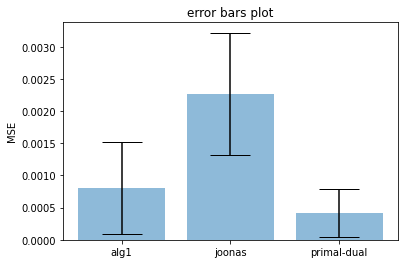

In [321]:
labels = ['alg1', 'joonas', 'primal-dual']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))
print()


print('joonas algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in joonas_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in joonas_scores]))
print()


print('primal dual algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in primal_dual_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in primal_dual_scores]))
print()

    
alg1_norm1_score = [item['total'] for item in alg1_scores]
joonas_score = [item['total'] for item in joonas_scores]
primal_dual_score = [item['total'] for item in primal_dual_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(joonas_score), 
    np.mean(primal_dual_score), 
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(joonas_score), 
    np.std(primal_dual_score), 
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## p2 plot

### My code

In [325]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

# B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)

num_tries = 5

from joblib import Parallel, delayed
import multiprocessing
def fun(K, samplingset, p2):
    B, weight_vec, features, true_labels, datapoints = get_sbm(c=2, p1=1.0, p2=p2, n_nodes=10, n_data=100, d_data=1)
    samplingset = random.sample([j for j in range(N)], k=int(0.5* N)) 
    _, predicted_w, _ = algorithm_1(K, B.copy(), weight_vec.copy(), 
                                 features.copy(), 
                                 true_labels.copy(), 
                                 samplingset.copy(), 
                                 datapoints.copy(),
                                 lambda_lasso=0.2, 
                                 alpha=0.02)
    alg1_score = get_algorithm1_w_MSE(predicted_w, samplingset.copy(), datapoints.copy())

    return alg1_score


from collections import defaultdict

alg1_p2_scores = defaultdict(list)
for p2 in [0.0, 0.02, 0.04, 0.06, 0.08]:
    for i in range(num_tries):
        alg1_score = fun(K, samplingset, p2)
        alg1_p2_scores[p2].append(alg1_score)


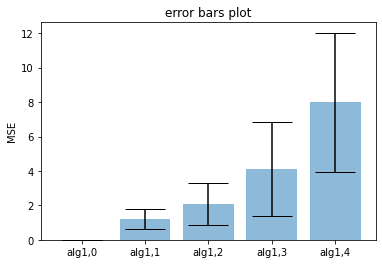

In [326]:
labels = ['alg1,0', 'alg1,1', 'alg1,2', 'alg1,3', 'alg1,4']
x_pos = np.arange(len(labels))

mean_MSEs = []

std_MSEs = []

for p2 in alg1_p2_scores:
    p2_scores = [item['total'] for item in alg1_p2_scores[p2]]
    mean_MSEs.append(np.mean(p2_scores))
    std_MSEs.append(np.std(p2_scores))


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

### Joona's code

In [277]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

# B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)

num_tries = 5

from joblib import Parallel, delayed
import multiprocessing
def fun(K, samplingset, p2):
    B, weight_vec, features, true_labels, datapoints = get_sbm(c=2, p1=1.0, p2=p2, n_nodes=10, n_data=100, d_data=1)
    samplingset = random.sample([j for j in range(N)], k=int(0.5* N)) 
    _, joona_w, _ = joonas_algorithm_1(K, B.copy(), weight_vec.copy(), 
                                       features.copy(), 
                                       true_labels.copy(), 
                                       samplingset, 
                                       lambda_lasso=0.1,
                                       a = 0.1)
    joona_score = get_algorithm1_w_MSE(joona_w, samplingset.copy(), datapoints.copy())

    return joona_score


from collections import defaultdict

joona_p2_scores = defaultdict(list)
for p2 in [0.0, 0.02, 0.04, 0.06, 0.08]:
    for i in range(num_tries):
        joona_score = fun(K, samplingset, p2)
        joona_p2_scores[p2].append(joona_score)



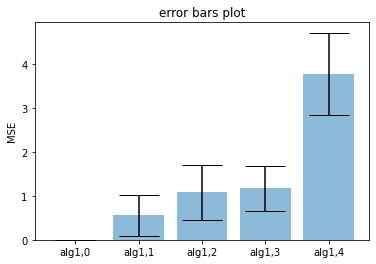

In [278]:
labels = ['alg1,0', 'alg1,1', 'alg1,2', 'alg1,3', 'alg1,4']
x_pos = np.arange(len(labels))

mean_MSEs = []

std_MSEs = []

for p2 in joona_p2_scores:
    p2_scores = [item['total'] for item in joona_p2_scores[p2]]
    mean_MSEs.append(np.mean(p2_scores))
    std_MSEs.append(np.std(p2_scores))


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## Results 

### Number of features: 10
### Number of datapoints per node: 100

In [336]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

# B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)
B, weight_vec, features, true_labels, datapoints = get_sbm(c=2, p1=1.0, p2=0.0, n_nodes=10, n_data=100, d_data=10)

num_tries = 5

from joblib import Parallel, delayed
import multiprocessing
def fun(K, B, weight_vec, features, datapoints, true_labels):
    E, N = B.shape
    samplingset = random.sample([j for j in range(N)], k=int(0.5* N)) 
    _, primal_dual_w = primal_dual_algorithm_1(K, B.copy(), weight_vec.copy(), 
                                               datapoints.copy(), 
                                               true_labels.copy(), 
                                               samplingset.copy(), 
                                               lambda_lasso=1.0)
    _, predicted_w, _ = algorithm_1(K, B.copy(), weight_vec.copy(), 
                                 features.copy(), 
                                 true_labels.copy(), 
                                 samplingset.copy(), 
                                 datapoints.copy(), 
                                 lambda_lasso=0.5, 
                                 alpha=0.02)
    _, joona_w, _ = joonas_algorithm_1(K, B.copy(), weight_vec.copy(), 
                                       features.copy(), 
                                       true_labels.copy(), 
                                       samplingset, 
                                       lambda_lasso=0.1,
                                       a = 0.1)
    
    alg1_score = get_algorithm1_w_MSE(predicted_w, samplingset.copy(), datapoints.copy())
    primal_dual_score = get_algorithm1_w_MSE(primal_dual_w, samplingset.copy(), datapoints.copy())
    joona_score = get_algorithm1_w_MSE(joona_w, samplingset.copy(), datapoints.copy())

    return alg1_score, primal_dual_score, joona_score


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

alg1_scores = []
joonas_scores = []
primal_dual_scores = []
for i in range(num_tries):
    alg1_score, primal_dual_score, joonas_score = fun(K, B, weight_vec, features, datapoints, true_labels)
    alg1_scores.append(alg1_score)
    joonas_scores.append(joonas_score)
    primal_dual_scores.append(primal_dual_score)





algorithm 1: 
 mean train MSE: 0.000510880646253296 
 mean test MSE: 0.0005531363045386331

joonas algorithm 1: 
 mean train MSE: 0.0007639780080335187 
 mean test MSE: 0.0005164261679019547

primal dual algorithm 1: 
 mean train MSE: 0.0005412693657797724 
 mean test MSE: 0.0003500545450250204



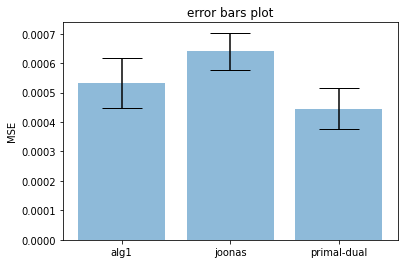

In [337]:
labels = ['alg1', 'joonas', 'primal-dual']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))
print()


print('joonas algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in joonas_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in joonas_scores]))
print()


print('primal dual algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in primal_dual_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in primal_dual_scores]))
print()

    
alg1_norm1_score = [item['total'] for item in alg1_scores]
joonas_score = [item['total'] for item in joonas_scores]
primal_dual_score = [item['total'] for item in primal_dual_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(joonas_score), 
    np.mean(primal_dual_score), 
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(joonas_score), 
    np.std(primal_dual_score), 
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## p2 plot

### my code

In [340]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

# B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)

num_tries = 5

from joblib import Parallel, delayed
import multiprocessing
def fun(K, samplingset, p2):
    B, weight_vec, features, true_labels, datapoints = get_sbm(c=2, p1=1.0, p2=p2, n_nodes=10, n_data=100, d_data=10)
    samplingset = random.sample([j for j in range(N)], k=int(0.5* N)) 
    _, predicted_w, _ = algorithm_1(K, B.copy(), weight_vec.copy(), 
                                 features.copy(), 
                                 true_labels.copy(), 
                                 samplingset.copy(),
                                 datapoints.copy(), 
                                 lambda_lasso=0.5, 
                                 alpha=0.02)
    alg1_score = get_algorithm1_w_MSE(predicted_w, samplingset.copy(), datapoints.copy())

    return alg1_score


from collections import defaultdict

alg1_p2_scores = defaultdict(list)
for p2 in [0.0, 0.02, 0.04, 0.06, 0.08]:
    for i in range(num_tries):
        alg1_score = fun(K, samplingset, p2)
        alg1_p2_scores[p2].append(alg1_score)



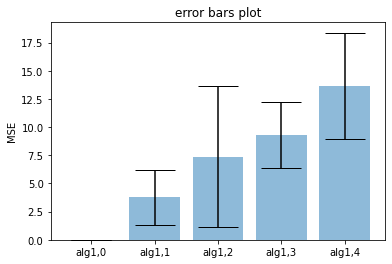

In [341]:
labels = ['alg1,0', 'alg1,1', 'alg1,2', 'alg1,3', 'alg1,4']
x_pos = np.arange(len(labels))

mean_MSEs = []

std_MSEs = []

for p2 in alg1_p2_scores:
    p2_scores = [item['total'] for item in alg1_p2_scores[p2]]
    mean_MSEs.append(np.mean(p2_scores))
    std_MSEs.append(np.std(p2_scores))


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

### Joona's code

In [282]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

# B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)

num_tries = 5

from joblib import Parallel, delayed
import multiprocessing
def fun(K, samplingset, p2):
    B, weight_vec, features, true_labels, datapoints = get_sbm(c=2, p1=1.0, p2=p2, n_nodes=10, n_data=100, d_data=10)
    samplingset = random.sample([j for j in range(N)], k=int(0.5* N)) 
    _, joona_w, _ = joonas_algorithm_1(K, B.copy(), weight_vec.copy(), 
                                       features.copy(), 
                                       true_labels.copy(), 
                                       samplingset, 
                                       lambda_lasso=0.1,
                                       a = 0.1)
    joona_score = get_algorithm1_w_MSE(joona_w, samplingset.copy(), datapoints.copy())

    return joona_score


from collections import defaultdict

joona_p2_scores = defaultdict(list)
for p2 in [0.0, 0.02, 0.04, 0.06, 0.08]:
    for i in range(num_tries):
        joona_score = fun(K, samplingset, p2)
        joona_p2_scores[p2].append(joona_score)




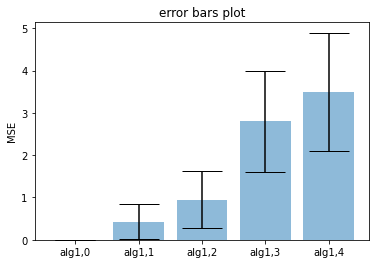

In [283]:
labels = ['alg1,0', 'alg1,1', 'alg1,2', 'alg1,3', 'alg1,4']
x_pos = np.arange(len(labels))

mean_MSEs = []

std_MSEs = []

for p2 in joona_p2_scores:
    p2_scores = [item['total'] for item in joona_p2_scores[p2]]
    mean_MSEs.append(np.mean(p2_scores))
    std_MSEs.append(np.std(p2_scores))


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

### Joona's SBM graph

In [108]:
def get_sbm(c, p1 = 0.4, p2 = 0.1, n_nodes = 10, n_data = 100):
    N_c = n_nodes
    N = N_c * c
    B = []
    weight_vec = []
    
    for i in range(c):
        for idx1 in range(n_nodes * i, n_nodes * (i + 1)):
            for idx2 in range(idx1 + 1, n_nodes * (i + 1)):
                if p1 > np.random.random():
                    b = np.zeros(N)
                    if idx1 < idx2:
                        b[idx1] = 1
                        b[idx2] = -1
                    else:
                        b[idx1] = -1
                        b[idx2] = 1
                    weight_vec.append(1)
                    B.append(b)
                
    # Add edges between components (intercomponent edges)
    for i in range(c):
        for idx1 in range(n_nodes * i, n_nodes * (i + 1)):
            for i2 in range(i+1, c):
                for idx2 in range(n_nodes * i2, n_nodes * (i2 + 1)):
                    if p2 > np.random.random():
                        b = np.zeros(N)
                        if idx1 < idx2:
                            b[idx1] = 1
                            b[idx2] = -1
                        else:
                            b[idx1] = -1
                            b[idx2] = 1
                        weight_vec.append(1)
                        B.append(b)
     
    B = np.array(B)
    weight_vec = np.array(weight_vec)
    
    datapoints = {}
    true_labels = []
    all_features = []
    # weights to generate labels from data
    ws = np.arange(1,c+1) * 10
    
    for i in range(c):
        w = ws[i]
        for idx in range(n_nodes * i, n_nodes * (i + 1)):
            # x sim N(0, I)
            features = np.random.normal(scale=np.ones(n_data))
            # y = w x + noise
            # w is same for all nodes in a component
            # noise sim N(0, 0.4)
            noise = np.random.normal(scale=np.ones(n_data) * 0.4)
            label = w * features + noise
            true_labels.append(label)

            datapoints[idx] = {
                'features': features.reshape((-1, 1)),
                'label': label
            }
            all_features.append(features.reshape((-1, 1)))
            
    return B, weight_vec, np.array(all_features), np.array(true_labels), datapoints

## Joona's implementation accuracy

In [379]:
p1s = np.linspace(0.1, 0.9, 9)
p2s = np.linspace(0.1, 0.7, 7)
lambda_lasso = 0.1

def experiment(iterk = 5, c = 2):
    K = 2000
    
    alg1_scores = defaultdict(list)
    n_nodes = 50
    scores_test = np.zeros((9,7,iterk))
    scores_total = np.zeros((9,7,iterk))
    pred_ws = defaultdict(list)
    n_iters = np.zeros((9,7,iterk))

    for k in range(iterk):
        for p1i in range(len(p1s)):
            p1 = p1s[p1i]
#             print(p1)
            for p2i in range(len(p2s)):
                p2 = p2s[p2i]
                
                B, weight_vec, all_features, true_labels, datapoints = get_sbm(c, p1=p1, p2=p2, n_nodes=n_nodes)
                E, N = B.shape

                samplingset = random.sample([i for i in range(N)], k=int(0.3 * N))
            
                _, predicted_w, iters = joonas_algorithm_1(K, B, weight_vec, all_features, true_labels, samplingset, lambda_lasso)
        

                pred_ws[p1,p2].append(predicted_w)
                alg1_score = get_algorithm1_MSE(all_features, true_labels, predicted_w, samplingset)
                alg1_scores[f'{p1}{p2}'].append(alg1_score)

                scores_test[p1i,p2i,k] = alg1_score['test']
                scores_total[p1i,p2i,k] = alg1_score['total']
                n_iters[p1i,p2i,k] = iters
    return alg1_scores, scores_test, scores_total, n_iters, pred_ws


In [380]:
expc2 = experiment(c = 2)


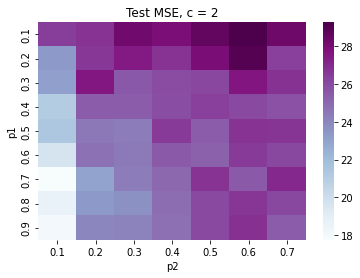

In [381]:

import seaborn as sns
sns.heatmap(expc2[1].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), cmap="BuPu")
plt.xlabel("p2")
plt.ylabel("p1")
plt.title("Test MSE, c = 2")
plt.show()

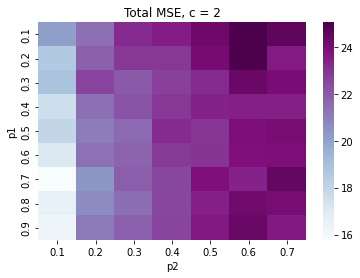

In [382]:
sns.heatmap(expc2[2].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), robust=False, cmap="BuPu")
plt.xlabel("p2")
plt.ylabel("p1")
plt.title("Total MSE, c = 2")
plt.show()

## Convergence speed w.r.t p1, p2

We measure the convergence speed of the networked algorithm with the number of iterations it takes to converge w.r.t $p1$, $p2$.
Convergence is reached when the train MSE difference of two subsequent iterations is less than $\epsilon = 0.005$.
It is worth noting that the number of clusters affects the convergence speed as well as it adds $n_{nodes}$ more nodes to the graph.
However, the number of iterations it takes to converge is not universal as it also depends on the optimizer of choice and the learning rate.
Yet, the results should give idea relative to the settings about the convergence speed.

Should also analyze big O for iteration time?

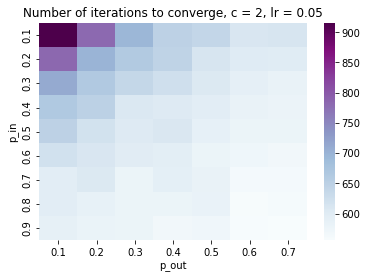

In [383]:
sns.heatmap(expc2[3].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Number of iterations to converge, c = 2, lr = 0.05")
plt.show()

## My implementation accuracy

In [378]:
p1s = np.linspace(0.1, 0.9, 9)
# p1s = np.linspace(0.1, 0.9, 2)
p2s = np.linspace(0.1, 0.7, 7)
# p2s = np.linspace(0.1, 0.7, 2)
lambda_lasso = 0.1

def my_experiment(iterk = 5, c = 2):
    K = 1000
    
    alg1_scores = defaultdict(list)
    n_nodes = 50
    pred_ws = defaultdict(list)
    scores_test = np.zeros((9,7,iterk))
    scores_total = np.zeros((9,7,iterk))
    n_iters = np.zeros((9,7,iterk))

    for k in range(iterk):
        for p1i in range(len(p1s)):
            p1 = p1s[p1i]
#             print(p1)
            for p2i in range(len(p2s)):
                p2 = p2s[p2i]
                
                B, weight_vec, all_features, true_labels, datapoints = get_sbm(c, p1=p1, p2=p2, n_nodes=n_nodes)
                E, N = B.shape

                samplingset = random.sample([i for i in range(N)], k=int(0.5 * N))
            
                _, predicted_w, iters = algorithm_1(K, B, weight_vec, all_features, true_labels, samplingset, datapoints, lambda_lasso)
        

#                 alg1_score, torch_linear_score, linear_regression_score, decision_tree_score = get_scores(datapoints, predicted_w, samplingset, c, n_nodes)
                pred_ws[p1,p2].append(predicted_w)
                alg1_score = get_algorithm1_MSE(all_features, true_labels, predicted_w, samplingset)
                alg1_scores[f'{p1}{p2}'].append(alg1_score)
                n_iters[p1i,p2i,k] = iters

                scores_test[p1i,p2i,k] = alg1_score['test']
                scores_total[p1i,p2i,k] = alg1_score['total']
    return alg1_scores, scores_test, scores_total, n_iters, pred_ws

my_expc2 = my_experiment(c = 2)



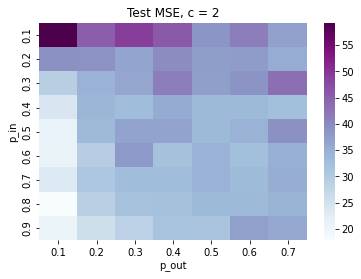

In [375]:
sns.heatmap(my_expc2[1].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), cmap="BuPu")

plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Test MSE, c = 2")
plt.show()

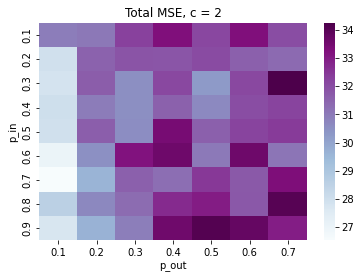

In [376]:
sns.heatmap(new_my_expc2[2].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), robust=False, cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Total MSE, c = 2")
plt.show()

## Convergence speed w.r.t p1, p2

We measure the convergence speed of the networked algorithm with the number of iterations it takes to converge w.r.t $p1$, $p2$.
Convergence is reached when the train MSE difference of two subsequent iterations is less than $\epsilon = 0.005$.
It is worth noting that the number of clusters affects the convergence speed as well as it adds $n_{nodes}$ more nodes to the graph.
However, the number of iterations it takes to converge is not universal as it also depends on the optimizer of choice and the learning rate.
Yet, the results should give idea relative to the settings about the convergence speed.

Should also analyze big O for iteration time?

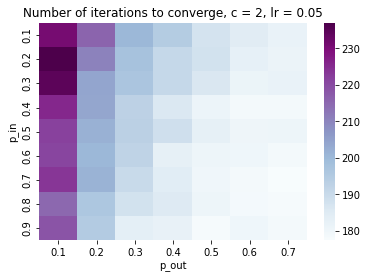

In [377]:
sns.heatmap(my_expc2[3].mean(-1), xticklabels=p2s, yticklabels=np.round(p1s,2), cmap="BuPu")
plt.xlabel("p_out")
plt.ylabel("p_in")
plt.title("Number of iterations to converge, c = 2, lr = 0.05")
plt.show()